In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [47]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [49]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data.csv'),
                    index_col=None)
merged.set_index('type_cw', inplace=True)
merged

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,,,,,,,,
A286-80,60.489458,0.010580,0.002000,0.002000,-1.409903,0.046787,0.002109,3.640283e+02,0.025513,2.594648,184.875799,0.018969,1.705626,-62.977927,A286
A286-80,44.261992,0.013681,0.002000,0.002000,-1.508575,0.046089,0.001903,4.615413e+02,0.022798,1.890054,901.546526,0.022046,1.504480,-64.434818,A286
A286-0,156.352240,0.014511,0.002000,0.002000,-1.220520,0.045382,0.002143,9.688812e-13,0.008521,3.973307,47.009106,0.002548,1.640369,-0.455673,A286
304-80,70.025254,4.788344,2.131362,2.820919,-1.055187,0.067237,0.002424,8.023317e+01,0.027521,3.165900,158.586692,0.024863,3.235830,-8.051534,304
304-40,102.089063,1.070462,0.821760,1.754141,-1.201403,0.052497,0.001934,4.029531e+01,0.022566,2.870203,637.420387,0.012983,5.242440,-36.263322,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-40,96.533556,0.338549,0.179534,0.225540,-1.261545,0.056277,0.002174,1.350067e+02,0.006515,1.112177,238.429845,0.023679,1.824403,-36.890105,347
A286-20,71.566934,0.009250,0.002000,0.002000,-1.150631,0.044825,0.002063,6.842860e+02,0.022014,1.675595,1292.052416,0.011407,0.373688,-28.171811,A286
304-80,81.170931,3.926854,2.239491,3.551210,-0.930937,0.067434,0.002443,8.748498e+01,0.023465,3.085555,139.648195,0.018672,2.814763,2.662860,304


In [50]:
# Seperating data depending on the type of steel
merged=merged[merged.index.isin(['347-0','347-20','347-40','347-60','347-80'])]

In [51]:
merged

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,,,,,,,,
347-80,74.711478,6.390457,2.201060,2.213508,-0.972557,0.053860,0.002405,160.538745,0.021068,2.262186,294.960348,0.010748,1.511315,-34.117022,347
347-20,103.608574,0.108630,0.056757,0.381720,-1.411095,0.051750,0.002035,265.981155,0.020065,2.783341,237.169152,0.059305,15.137927,-39.542790,347
347-20,101.822286,0.475480,0.060899,0.525100,-1.321678,0.051649,0.002045,225.201981,0.022945,2.627998,218.637989,0.056433,8.586838,-17.497911,347
347-60,73.482724,3.719479,1.645914,2.849523,-1.127134,0.059886,0.002473,205.331690,0.029162,3.715914,231.366426,0.012543,2.353366,-47.185288,347
347-80,70.677823,6.390989,2.425881,2.597162,-0.862652,0.075765,0.002519,228.017743,0.018774,2.274455,281.432042,0.009800,1.082098,-44.355326,347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-20,120.721493,0.825774,0.604327,0.213455,-1.347732,0.051289,0.001811,263.786551,0.021050,2.814220,174.690063,0.080282,8.186876,-38.948824,347
347-80,57.637016,6.150100,2.755414,3.234313,-0.802753,0.060766,0.002554,263.994804,0.016352,1.948052,339.360095,0.009513,1.265813,-52.577316,347
347-40,83.099000,0.790224,0.434450,0.615027,-1.358207,0.060527,0.002031,266.068210,0.007609,0.828786,279.011961,0.025623,3.053579,-38.833425,347


## Select columns of interest

In [52]:
merged.drop(["Type"], axis=1, inplace=True)

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Scale data

In [53]:
# The logarithmic of the KJIC is incorporated for better results
merged.KJIC = np.log(merged.KJIC)
scaled_df = mc.scale_general(merged, MinMaxScaler())
scaled_df[0]

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS
type_cw,,,,,,,,,,,,,,
347-80,0.220568,0.999915,0.584882,0.437976,0.713314,0.094996,0.647849,0.367056,0.607640,0.253849,0.312803,0.111744,0.048524,0.364406
347-20,0.473552,0.015532,0.014289,0.075200,0.215983,0.059461,0.314931,0.608139,0.575593,0.329305,0.266356,0.732032,0.904575,0.281245
347-20,0.460097,0.073018,0.015392,0.103596,0.317388,0.057763,0.323666,0.514902,0.667626,0.306813,0.251463,0.695346,0.493022,0.619127
347-60,0.207738,0.581364,0.437159,0.563936,0.538014,0.196479,0.708896,0.469470,0.866348,0.464327,0.261693,0.134685,0.101423,0.164109
347-80,0.177627,0.999998,0.644706,0.513957,0.837954,0.463897,0.750249,0.521340,0.534304,0.255625,0.301930,0.099640,0.021559,0.207484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-20,0.591822,0.127911,0.159996,0.041876,0.287841,0.051690,0.113605,0.603121,0.607051,0.333775,0.216142,1.000000,0.467896,0.290349
347-80,0.019821,0.962250,0.732393,0.640141,0.905883,0.211299,0.782273,0.603597,0.456901,0.208367,0.348487,0.095978,0.033101,0.081465
347-40,0.302887,0.122340,0.114793,0.121406,0.275962,0.207274,0.311382,0.608338,0.177439,0.046314,0.299985,0.301768,0.145412,0.292118


<AxesSubplot:>

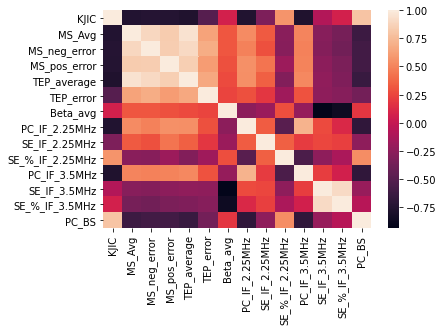

In [54]:
sns.heatmap(merged.corr())

In [55]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = scaled_df[0].drop('KJIC', axis = 1)
y = scaled_df[0]['KJIC']

In [56]:
X

,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS
type_cw,,,,,,,,,,,,,
347-80,0.999915,0.584882,0.437976,0.713314,0.094996,0.647849,0.367056,0.607640,0.253849,0.312803,0.111744,0.048524,0.364406
347-20,0.015532,0.014289,0.075200,0.215983,0.059461,0.314931,0.608139,0.575593,0.329305,0.266356,0.732032,0.904575,0.281245
347-20,0.073018,0.015392,0.103596,0.317388,0.057763,0.323666,0.514902,0.667626,0.306813,0.251463,0.695346,0.493022,0.619127
347-60,0.581364,0.437159,0.563936,0.538014,0.196479,0.708896,0.469470,0.866348,0.464327,0.261693,0.134685,0.101423,0.164109
347-80,0.999998,0.644706,0.513957,0.837954,0.463897,0.750249,0.521340,0.534304,0.255625,0.301930,0.099640,0.021559,0.207484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-20,0.127911,0.159996,0.041876,0.287841,0.051690,0.113605,0.603121,0.607051,0.333775,0.216142,1.000000,0.467896,0.290349
347-80,0.962250,0.732393,0.640141,0.905883,0.211299,0.782273,0.603597,0.456901,0.208367,0.348487,0.095978,0.033101,0.081465
347-40,0.122340,0.114793,0.121406,0.275962,0.207274,0.311382,0.608338,0.177439,0.046314,0.299985,0.301768,0.145412,0.292118


In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# Creating the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(179,)
(78, 13)


## Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
lr = LinearRegression()

In [61]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

0.5693789642318792


,Coefficient
MS_Avg,-0.010788
MS_neg_error,-0.176112
MS_pos_error,-0.208341
TEP_average,-0.018049
TEP_error,-0.029150
Beta_avg,0.075895
PC_IF_2.25MHz,-0.135602
SE_IF_2.25MHz,-0.295951
SE_%_IF_2.25MHz,0.480957
PC_IF_3.5MHz,-0.405116


In [63]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

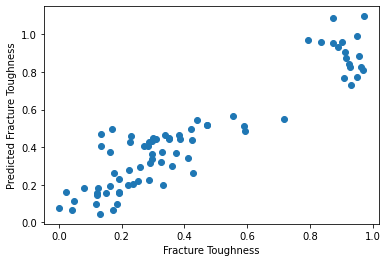

In [64]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [65]:
from sklearn import metrics

In [66]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.09425550173938928
MSE: 0.013935209731258866
RMSE: 0.11804748930518966


## Ridge Regression

In [67]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.09779040200248153
0.8916378052861667
0.11800053825612936
0.8442708234382861


Text(0, 0.5, 'Predicted Fracture Toughness')

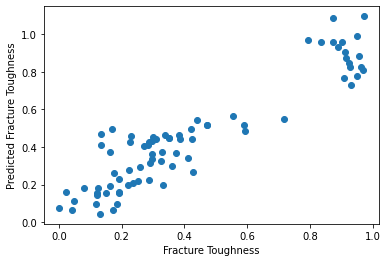

In [68]:
plt.scatter(y_test,pred_test_rr)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Elastic net

In [69]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.11336235663954355
0.8543793179316428
0.1284054639455564
0.8155965596613639


Text(0, 0.5, 'Predicted Fracture Toughness')

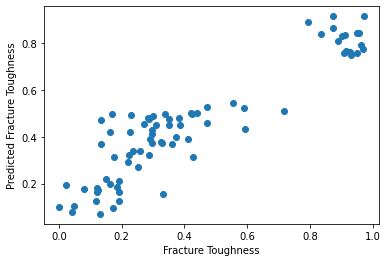

In [70]:
plt.scatter(y_test,pred_test_enet)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Lasso 

In [71]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

0.12889167592375217
0.8117499627236979
0.14183273991737014
0.7750142583221435


Text(0, 0.5, 'Predicted Fracture Toughness')

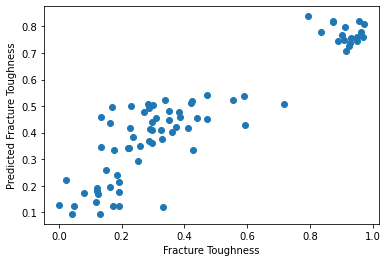

In [72]:
plt.scatter(y_test,pred_test_lasso)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")